In [1]:
%load_ext autoreload
%autoreload 2
from cs285.envs.pendulum.pendulum_env import PendulumEnv
from cs285.envs.dt_sampler import ConstantSampler, UniformSampler, ExponentialSampler
from cs285.infrastructure.replay_buffer import ReplayBufferTrajectories
from cs285.infrastructure.utils import sample_n_trajectories, RandomPolicy
from cs285.agents.ode_agent import ODEAgent
from cs285.agents.nueral_ode import Base_NeuralODE, NeuralODE_Vanilla, Pendulum_True_Dynamics, NeuralODE_Augmented, NeuralODE_Latent_MLP, ODE_RNN
from cs285.agents.utils import save_leaves, load_leaves
from cs285.infrastructure import utils
from cs285.scripts.notebook_utils import train, test
from typing import Callable, Optional, Tuple, Sequence
import numpy as np
import gym
from cs285.infrastructure import pytorch_util as ptu
from tqdm import trange
import jax
import jax.numpy as jnp
import equinox as eqx
import diffrax
from diffrax import diffeqsolve, Dopri5
import optax
import pickle
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
key = jax.random.PRNGKey(0)
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
dt_key, key = jax.random.split(key)
dt_sampler = ExponentialSampler(lmbda=20, key=dt_key)
dt_key, key = jax.random.split(key)
mpc_dt_sampler = ExponentialSampler(lmbda=20, key=dt_key)
env = PendulumEnv(dt_sampler=dt_sampler)

agent_key, key = jax.random.split(key)
neural_ode_name = "latent_mlp"
mlp_setup = {
    "hidden_size": 128,
    "num_layers": 4,
    "activation": "tanh",
    "output_activation": "identity",
}
neural_ode_kwargs = {
    "ode_dt0": 0.05,
    "mlp_dynamics_setup": mlp_setup,
    "mlp_ob_encoder_setup": mlp_setup,
    "mlp_ac_encoder_setup": mlp_setup,
    "mlp_ob_decoder_setup": mlp_setup,
    "ac_latent_dim": 16,
    "ob_latent_dim": 16,
}
optimizer_name = "adamw"
optimizer_kwargs = {"learning_rate": 1e-3}
mb_agent = ODEAgent(
    env=env,
    key=agent_key,
    neural_ode_name=neural_ode_name,
    neural_ode_kwargs=neural_ode_kwargs,
    optimizer_name=optimizer_name,
    optimizer_kwargs=optimizer_kwargs,
    ensemble_size=1,
    train_discount=1,
    mpc_horizon_steps=20,
    mpc_dt_sampler=mpc_dt_sampler,
    mpc_strategy="random",
    mpc_discount=0.95,
    mpc_num_action_sequences=1000,
    cem_num_iters=4,
    cem_num_elites=5,
    cem_alpha=1,
)
with open("../../../reply_buffers/random_exponential_20_replay_buffer", "rb") as f:
    replay_buffer = pickle.load(f)

100%|██████████| 10/10 [01:01<00:00,  6.19s/it]

mean -1168.8157
std 281.00327
min -1609.0234
max -654.1453


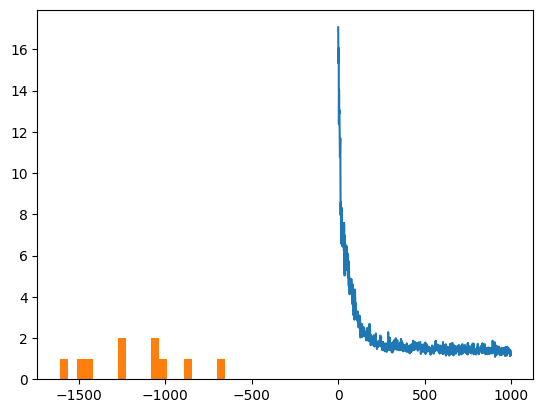

In [4]:
train_config = {
    "batch_size": 64,
    "steps": 1000,
    "ep_len": 20,
    "stride": 1,
    "discount": 1.0,
}
train_key, key = jax.random.split(key)
mb_agent, losses = train(mb_agent, 0, replay_buffer, train_config, key=train_key)
save_leaves(mb_agent, "agent")
with open("train_losses", "wb") as f:
    pickle.dump(losses, f)
test_key, key = jax.random.split(key)
rewards, stats = test(mb_agent, 10, key=test_key, plot=True)
with open("eval_stats", "wb") as f:
    pickle.dump(stats, f)
with open("eval_rewards", "wb") as f:
    pickle.dump(rewards, f)